# 4 - Modelagem
Nesta etapa, vamos avaliar quais modelos de regressão apresentam melhores resultados para prever a variável alvo. Iniciaremos identificando um modelo base e comparando a performance com os modelos de regressão. As métricas de avaliação serão o RMSE, MAE e R2.

In [145]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

## Setup do notebook

- Configurações gerais do notebook. Para ignorar avisos e configurações de tema para os gráficos.
- Configurar que os gráficos sejam exibidos inline no notebook.
- Configurar a semente para os geradores de números aleatórios para garantir reprodutibilidade.

In [146]:
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style = "whitegrid")
%matplotlib inline

In [147]:
%reload_ext watermark
%watermark -a "Tech Challenge - Grupo 56" --iversions

Author: Tech Challenge - Grupo 56

xgboost    : 3.0.2
numpy      : 2.2.6
pandas     : 2.2.3
scipy      : 1.15.3
matplotlib : 3.10.3
joblib     : 1.5.1
sklearn    : 1.6.1
statsmodels: 0.14.4
seaborn    : 0.13.2
platform   : 1.0.8



# Funções

In [148]:
def modelo_base(dataset, var_independente, var_target):
    X = dataset[var_independente]
    y = dataset[var_target]

    X = pd.get_dummies(X, drop_first=True) 

    X = sm.add_constant(X)
    modelo_base = sm.OLS(y, X).fit()

    y_pred = modelo_base.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return {
        "modelo": "sm.OLS statsmodels",
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    } , modelo_base


In [149]:
def analise_estatistica_graficos(dataframe, coluna, titulo = ""):

    """
        Função: Indentificar e visualizar outliers (valores discrepantes). 
        Objetivo: Calcular Q1, Q3 e IQR (medidas estatísticas da distribuição), os outliers e exibir informações estatísticas importantes sobre a distribuição dos dados.
        Paramêtros: dataframe, coluna a variável alvo de análise e opcional o título do gráfico.
        Retorno: Retorna um dicionário com os valores calculados e os DataFrames contendo os outliers
    """
    mean = dataframe[coluna].mean() 
    std = dataframe[coluna].std()
    median = dataframe[coluna].median()
    skew = dataframe[coluna].skew()
    kurt = dataframe[coluna].kurtosis()
    MIN  = dataframe[coluna].min()
    MAX  = dataframe[coluna].max()    
    Q1     = dataframe[coluna].quantile(0.25)
    Q3     = dataframe[coluna].quantile(0.75)
    IQR    = Q3 - Q1
    CUT_OFF = 1.5 * IQR
    limite_inf_1_5  = Q1 - CUT_OFF
    limite_sup_1_5  = Q3 + CUT_OFF

    outliers_1_5 = dataframe[(dataframe[coluna] < limite_inf_1_5) | (dataframe[coluna] > limite_sup_1_5)]

    print("Q1:", Q1)
    print("Q3:", Q3)
    print("IQR (Interquartile Range):", IQR)
    print("--------------------------------------")
    print("Limite inferior 1.5:", limite_inf_1_5)
    print("Limite superior 1.5:", limite_sup_1_5)
    print(f"Número de outliers 1.5: {outliers_1_5.shape[0]}")

    data = dataframe[coluna].dropna()
    try:
        data = data.str.replace(',', '.').astype(float)
    except AttributeError:
        data = data.astype(float)

    fig, axs = plt.subplots(2, 1, figsize=(16, 8), 
                            gridspec_kw={'height_ratios': [0.25, 0.7], 'hspace': 0.00},
                            sharex=True)

    # Boxplot com Seaborn
    sns.boxplot(x=data, ax=axs[0], color='lightgreen', fliersize=4, linewidth=1, width=0.4)

    axs[0].axvline(mean, color='green', linestyle='--', linewidth=2, label='Média')
    axs[0].axvline(median, color='purple', linestyle='-.', linewidth=2, label='Mediana')
    axs[0].set_ylabel("Freq. Absoluta")
    axs[0].legend(loc='upper right')
    axs[0].set_title(f'{titulo}\n\n Boxplot e Distribuição da variável "{coluna}" \n\n')
    sns.histplot(data, kde=True, stat='count', bins=20, color='skyblue', edgecolor='black', ax=axs[1])
    if std == 0 or np.isnan(std):
        std = 1e-6

    axs[1].axvline(mean, color='green', linestyle='--', linewidth=2, label='Média')
    axs[1].axvline(median, color='purple', linestyle='-.', linewidth=2, label='Mediana')
    if limite_inf_1_5 > 0:
        axs[1].axvline(limite_inf_1_5, linestyle='--', color='darkblue', linewidth=2, alpha=1, label='Limite Inferior')
    if limite_sup_1_5 > 0:
        axs[1].axvline(limite_sup_1_5, linestyle='--', color='darkblue', linewidth=2, alpha=1, label='Limite Superior')

    outliers = data[(data < limite_inf_1_5) | (data > limite_sup_1_5)]
    axs[1].scatter(outliers, np.zeros_like(outliers), color='red', zorder=5)

    stats_text = '\n'.join((
        f'Média: {mean:,.2f}',
        f'Mediana: {median:,.2f}',
        f'Desvio Padrão: {std:,.2f}',
        f'Assimetria: {skew:.2f}',
        f'Curtose: {kurt:.2f}',
        f'Mínimo: {MIN:,.2f}',
        f'Máximo: {MAX:,.2f}',
        f'Q1: {Q1:,.2f}',
        f'Q3: {Q3:,.2f}'
    ))

    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[1].text(0.30, 0.95, stats_text, transform=axs[1].transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

    axs[1].set_xlabel(coluna)
    axs[1].set_ylabel('Frequência Absoluta')
    axs[1].legend()
    axs[0].grid(False)
    axs[1].grid(False)

    plt.tight_layout()
    plt.show()

In [150]:
def avaliar_modelos_regressao(df, var_independente, var_target, categoricas=None, test_size=0.4, random_state=42):
    X = df[var_independente]
    y = df[var_target]

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

    print(f"Tamanho do treino: {X_train.shape[0]}")
    print(f"Tamanho da validação: {X_val.shape[0]}")
    print(f"Tamanho do teste: {X_test.shape[0]}\n")

    modelos = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(random_state=random_state),
        'Lasso': Lasso(random_state=random_state),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=random_state),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=random_state),
        'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=random_state)
    }

    transformers = [('num', StandardScaler(), var_independente)]
    if categoricas:
        transformers.append(('cat', OneHotEncoder(drop='first'), categoricas))

    preprocessor = ColumnTransformer(transformers=transformers)

    resultados = []
    melhor_rmse = np.inf
    melhor_modelo_nome = None
    melhor_pipeline = None

    for nome, modelo in modelos.items():
        pipeline = Pipeline([
            ('preprocessador', preprocessor),
            ('regressor', modelo)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
        cv_rmse = -cv_scores.mean()

        resultados.append({
            'Modelo': nome,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'CV_RMSE': cv_rmse
        })

        if rmse < melhor_rmse:
            melhor_rmse = rmse
            melhor_modelo_nome = nome
            melhor_pipeline = pipeline

    df_resultados = pd.DataFrame(resultados).sort_values('RMSE').reset_index(drop=True)
    print(df_resultados)

    y_test_pred = melhor_pipeline.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'\n✅ Melhor modelo: {melhor_modelo_nome}')
    print(f'📊 RMSE no teste: {rmse_test:.2f}')

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    axes[0].bar(df_resultados['Modelo'], df_resultados['RMSE'], color='mediumpurple')
    axes[0].set_title('Comparação de RMSE (menor é melhor)')
    axes[0].set_ylabel('RMSE')
    axes[0].tick_params(axis='x', rotation=45)

    axes[1].bar(df_resultados['Modelo'], df_resultados['MAE'], color='mediumseagreen')
    axes[1].set_title('Comparação de MAE (menor é melhor)')
    axes[1].set_ylabel('MAE')
    axes[1].tick_params(axis='x', rotation=45)

    axes[2].bar(df_resultados['Modelo'], df_resultados['R2'], color='cornflowerblue')
    axes[2].set_title('Comparação de R² (maior é melhor)')
    axes[2].set_ylabel('R²')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return df_resultados, melhor_pipeline


In [151]:
df_dados = pd.read_csv("data/dados_projeto_analise.csv")
df_dados.shape

(945, 20)

In [152]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      945 non-null    int64  
 1   Diabetes                 945 non-null    int64  
 2   BloodPressureProblems    945 non-null    int64  
 3   AnyTransplants           945 non-null    int64  
 4   AnyChronicDiseases       945 non-null    int64  
 5   Height                   945 non-null    int64  
 6   Weight                   945 non-null    int64  
 7   KnownAllergies           945 non-null    int64  
 8   HistoryOfCancerInFamily  945 non-null    int64  
 9   NumberOfMajorSurgeries   945 non-null    int64  
 10  PremiumPrice             945 non-null    int64  
 11  faixa_etaria             945 non-null    object 
 12  ordem_faixa              945 non-null    int64  
 13  imc                      945 non-null    float64
 14  categoria_imc            9

# Modelo Base

In [153]:
# Construindo o modelo base para servir de referência
# Variável Dependente (y) e Variáveis Independentes (X)
var_independente = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'imc', 'Age']
var_target = ['PremiumPrice']

metrica_v1, modelo_v1 = modelo_base(df_dados, var_independente, var_target)
print(metrica_v1)
modelo_v1.summary()

{'modelo': 'sm.OLS statsmodels', 'RMSE': np.float64(3412.493595486661), 'MAE': 2522.1685121377486, 'R2': 0.6838254937618511}


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     253.0
Date:                Fri, 30 May 2025   Prob (F-statistic):          5.13e-228
Time:                        23:41:20   Log-Likelihood:                -9028.7
No. Observations:                 945   AIC:                         1.808e+04
Df Residuals:                     936   BIC:                         1.812e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    5410.8246    702.532      7.702      0.000    4032.104    6789.545
Diabetes                 -344.2987    233.651     -1.474      0.141    -802.839     114.241
BloodPressureProblems     -74.9789    235.290     -0.319      0.750    -536.735     386.777
AnyTransplants           8413.5385    494.927     17.000      0.000    7442.243    9384.834
AnyChronicDiseases       2765.3894    289.829      9.541      0.000    2196.600    3334.179
HistoryOfCancerInFamily  2329.7202    360.262      6.467      0.000    1622.706    3036.734
NumberOfMajorSurgeries   -677.5809    171.553     -3.950      0.000   -1014.254    -340.908
imc                       158.8733     22.028      7.212      0.000     115.643     202.103
Age                       332.9709      9.203     36.182      0.000     314.911     351.031
==============================================================================
Omnibus:                       71.497   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.048
Skew:                           0.343   Prob(JB):                     4.48e-48
Kurtosis:                       5.251   Cond. No.                         324.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Interpretação:

Modelo Base de Regressão Linear da biblioteca statsmodels OLS gerou o R2 0.684, ou seja explica 68.4% da variabilidade dos dados. Esse valor serve como referência para aplicação de modelos mais robustos.

E como já identificado as variáveis Diabetes(p-valor 0.141) e BloodPressureProblems(p-valor 0.750) com p-valor acima de 0.05 não são significamente representativas para o modelo e serão retiradas para o treinamento do modelo.
  

# Avaliar Modelos de Regressão

Tamanho do treino: 567
Tamanho da validação: 189
Tamanho do teste: 189

             Modelo         RMSE          MAE        R2      CV_RMSE
0           XGBoost  2909.924226  1681.717896  0.788415  2537.251929
1  GradientBoosting  3029.090199  1711.255386  0.770731  2558.105267
2      RandomForest  3047.619940  1476.719577  0.767917  2481.703048
3  LinearRegression  3619.667755  2664.148468  0.672615  3364.491761
4             Lasso  3620.235671  2664.459555  0.672512  3364.489277
5             Ridge  3620.691158  2665.422651  0.672430  3364.399395

✅ Melhor modelo: XGBoost
📊 RMSE no teste: 2492.63


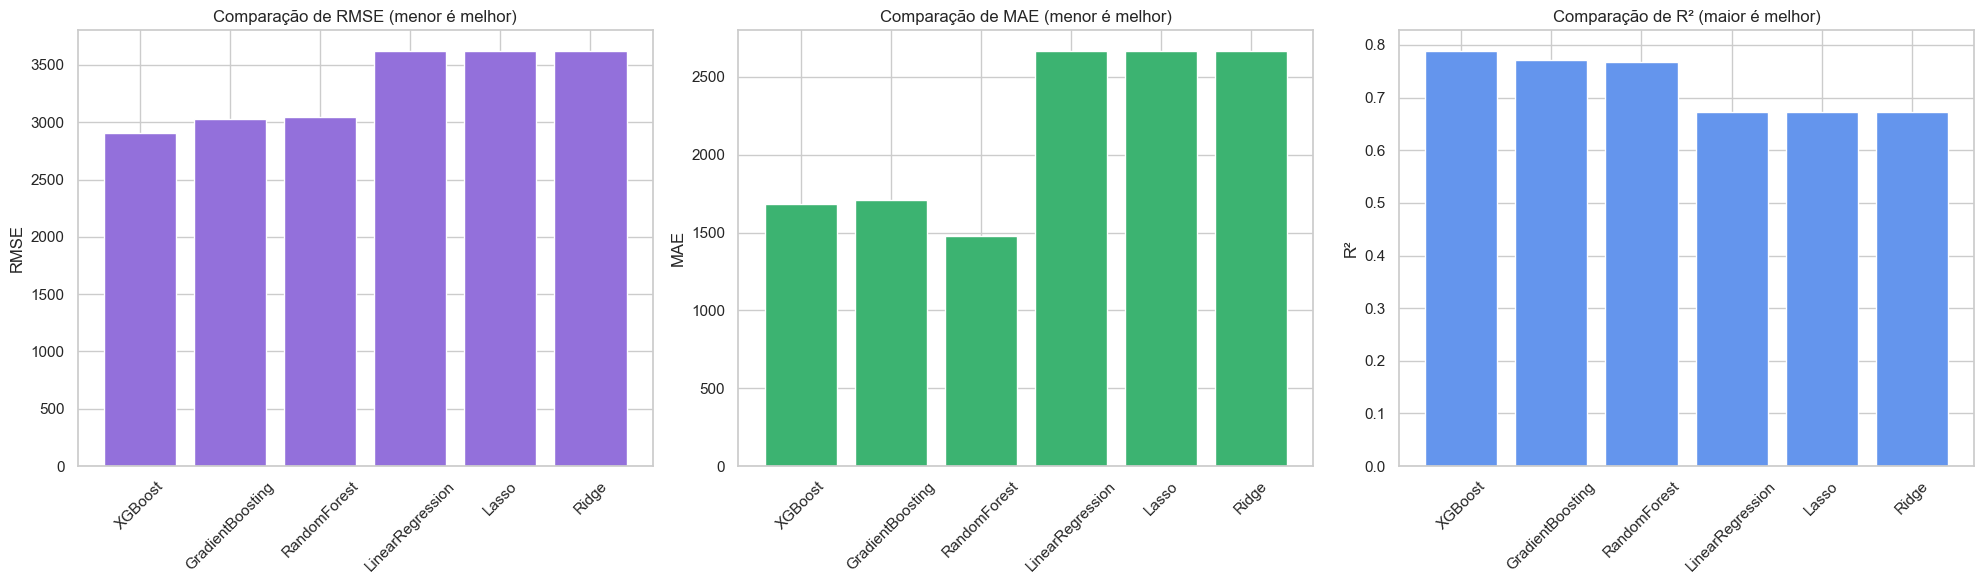

In [154]:
variaveis_indep = ['AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'Age', 'imc']
target = 'PremiumPrice'
resultados, modelo_final = avaliar_modelos_regressao(df_dados, variaveis_indep, target)

> Interpretação:

O modelo XGBoost apresentou bons resultados perante aos demais e com base na métrica RMSE que é a raiz quadrada do erro quadrático médio. Essa métrica mede a diferença média entre os valores previstos pelo modelo e os valores reais, penalizando erros maiores com mais força (por isso o quadrado).

A RMSE indica em média quando o modelo erra na unidade da variavel-alvo (target). Neste caso o modelo está errando em média 2992.63 de valores monetários para previsão por ano. Nesse sentido quanto menor o RMSE, melhor será o desempenho do modelo. A métrica R2 também bastante utilizada ficou em 0.78, ou seja, 78% de poder explicativo com base nas variáveis independentes, então quanto maior melhor.

Q1: 28000.0
Q3: 28000.0
IQR (Interquartile Range): 0.0
--------------------------------------
Limite inferior 1.5: 28000.0
Limite superior 1.5: 28000.0
Número de outliers 1.5: 1


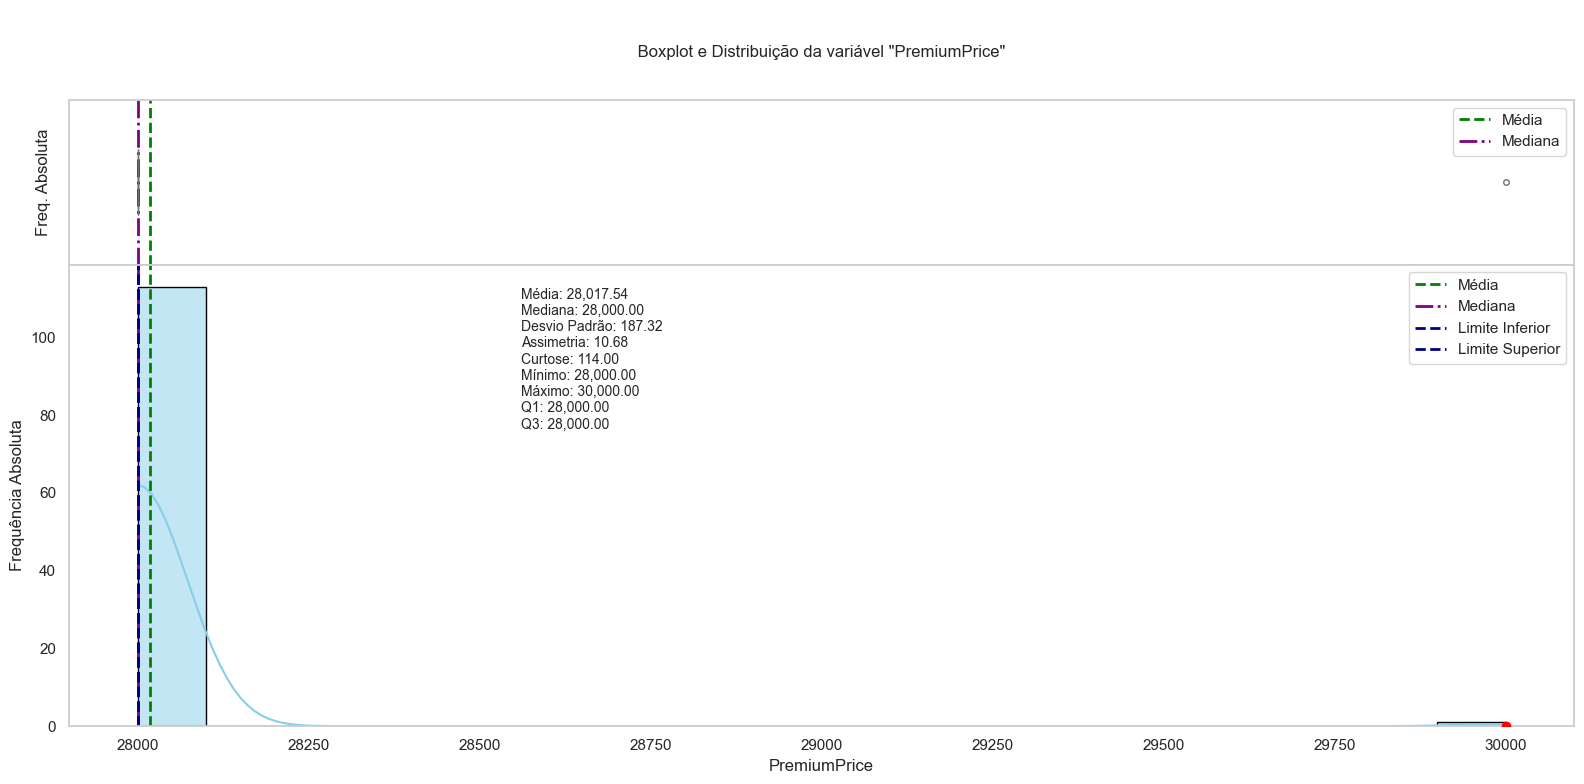

In [155]:
# Filtrar o DataFrame
df_filtrado = df_dados[(df_dados['NumberOfMajorSurgeries'] == 2)]
analise_estatistica_graficos(df_filtrado, 'PremiumPrice' )

In [156]:
# Identifica os índices dos registros considerados outliers
outliers_idx = df_dados[
    (df_dados['NumberOfMajorSurgeries'] == 2) &
    (df_dados['PremiumPrice'] > 28000)
].index

df_dados.drop(index=outliers_idx, inplace=True)
df_dados.reset_index(drop=True, inplace=True)
print(df_dados.shape)

(944, 20)


> Interpretação:

Continuando as análises variável por variável, encontramos um único outlier na condição de pessoas com histórico de 2 cirurgias, e que ao removê-lo melhorou significaticamente a performance do modelo.


Tamanho do treino: 566
Tamanho da validação: 189
Tamanho do teste: 189

             Modelo         RMSE          MAE        R2      CV_RMSE
0           XGBoost  2501.227199  1576.969849  0.850616  2678.532324
1  GradientBoosting  2717.498629  1689.815781  0.823666  2709.689012
2      RandomForest  2759.404794  1506.825397  0.818185  2644.595644
3  LinearRegression  3629.123920  2734.799329  0.685514  3413.806191
4             Lasso  3629.470236  2734.930812  0.685454  3413.800400
5             Ridge  3630.189774  2736.023939  0.685329  3413.750079

✅ Melhor modelo: XGBoost
📊 RMSE no teste: 2852.13


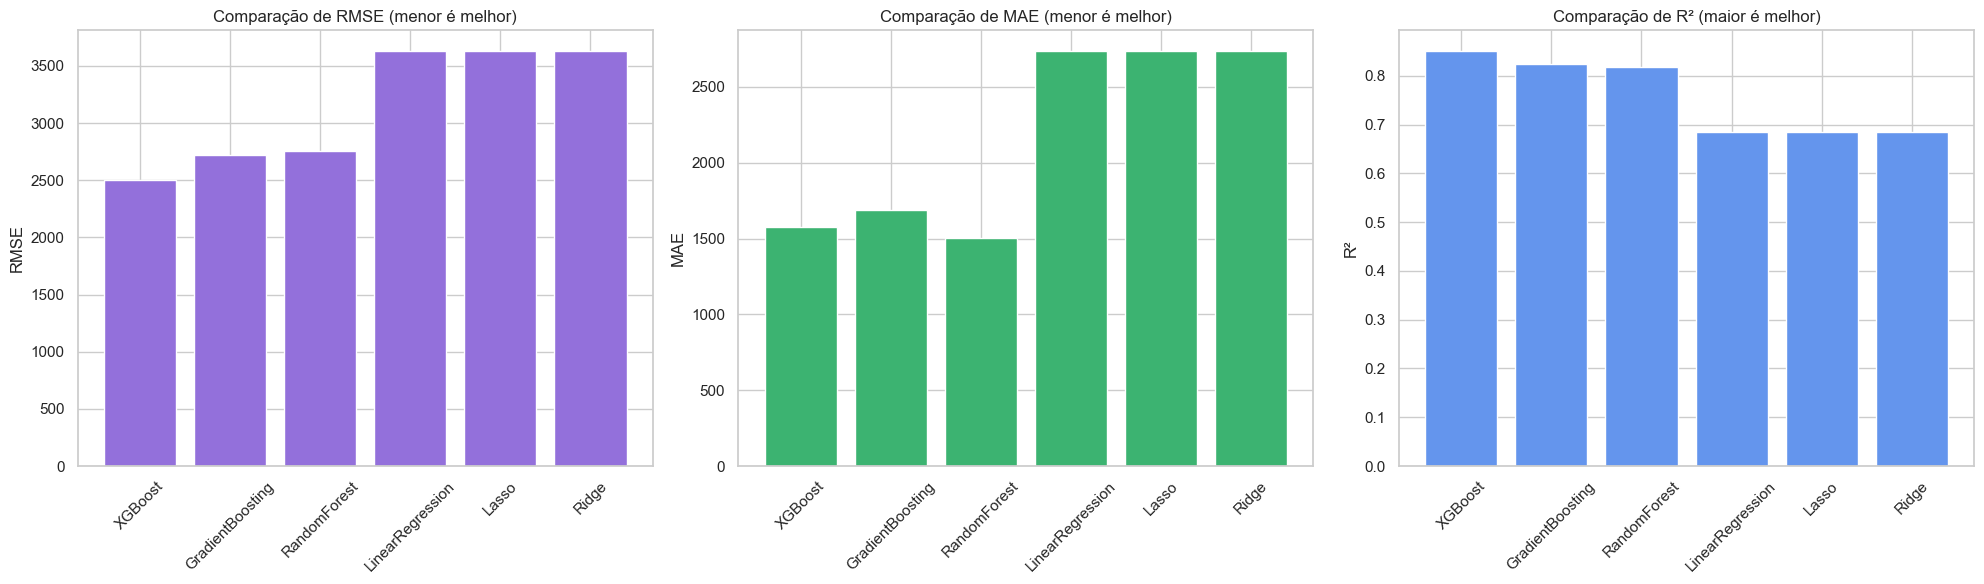

In [157]:
variaveis_indep = ['AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'Age', 'imc']
target = 'PremiumPrice'

resultados, modelo_final = avaliar_modelos_regressao(df_dados, variaveis_indep, target)

| Modelo XGBoost     | R² (Teste) | RMSE (Teste) | MAE (Teste) | CV_RMSE |
|--------------------|------------|---------------|--------------|----------|
| Com outlier        | 0.7884     | 2909.92       | 1681.71      | 2537.25  |
| Sem outlier        | 0.8506 ✅  | 2501.22 ✅    | 1576.97 ✅   | 2678.53  |

>Decisão

Modelo selecionado: XGBoost (sem outlier)

Melhor equilíbrio entre precisão preditiva e generalização

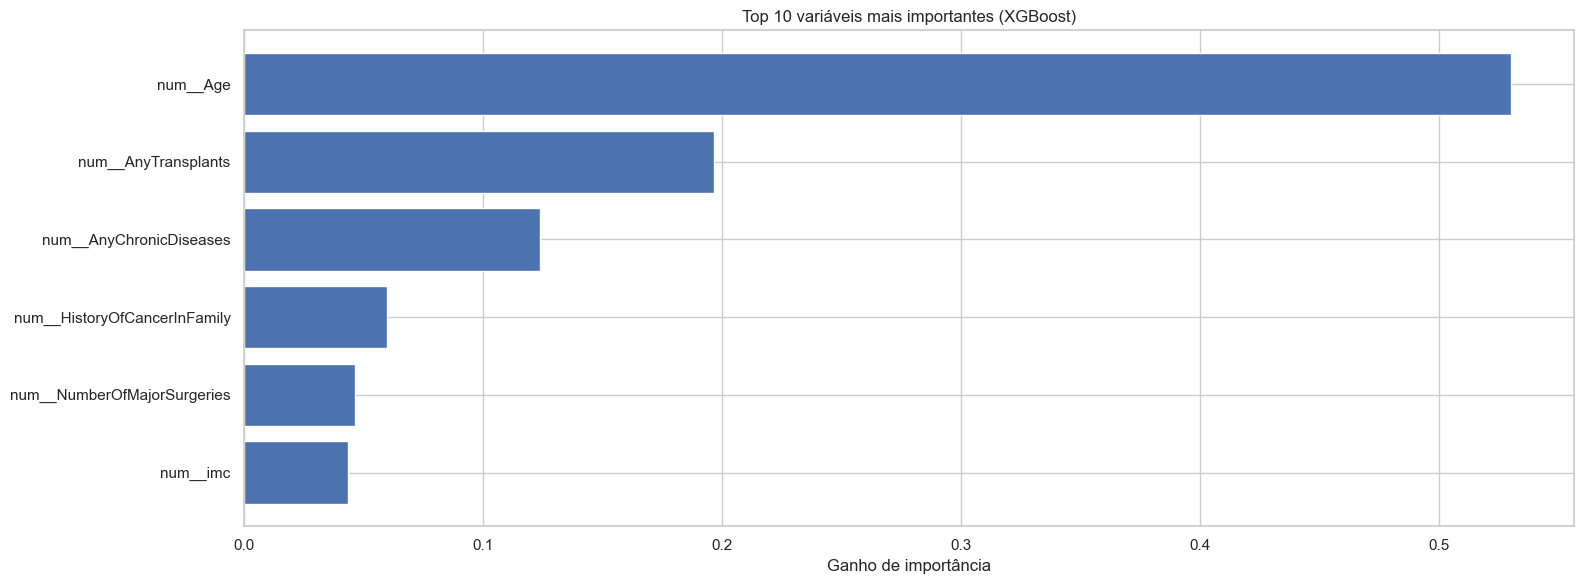

,feature,importance
4,num__Age,0.529882
0,num__AnyTransplants,0.196747
1,num__AnyChronicDiseases,0.123711
2,num__HistoryOfCancerInFamily,0.059771
3,num__NumberOfMajorSurgeries,0.046298


In [ ]:
# Extrair o modelo e o preprocessor
preprocessor = modelo_final.named_steps['preprocessador']
regressor = modelo_final.named_steps['regressor']

feature_names = preprocessor.get_feature_names_out()
importances = regressor.feature_importances_

importancia_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

importancia_df = importancia_df.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(16, 6))
plt.barh(importancia_df['feature'][::-1], importancia_df['importance'][::-1])  # Inverter para maiores no topo
plt.xlabel("Ganho de importância")
plt.title("Top 10 variáveis mais importantes (XGBoost)")
plt.tight_layout()
plt.show()
importancia_df.head()

# Salvar o melhor modelo

In [ ]:
import joblib

joblib.dump(modelo_final, './model/melhor_modelo.pkl')

['./model/melhor_modelo.pkl']

In [ ]:
# Para carregar o modelo salvo
modelo_carregado = joblib.load('model/melhor_modelo.pkl')

novo_paciente = {
    'AnyTransplants': [1],
    'AnyChronicDiseases': [1],
    'HistoryOfCancerInFamily': [1],
    'NumberOfMajorSurgeries': [2],
    'Age': [45],
    'imc': [32.0]
}

X_novo = pd.DataFrame(novo_paciente)
y_novo = modelo_carregado.predict(X_novo)
print(f"💰 Preço estimado do seguro: R$ {y_novo[0]:.2f}")

💰 Preço estimado do seguro: R$ 33871.38
